In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import spikeinterface.full as si
from sparsesorter.models.nss import NSS
from sparsesorter.utils.metrics import compute_fscore_evolution, SortingMetrics
from sparsesorter.utils.dataloader import (
    build_dataloader,
    init_dataloader,
    compute_detection_performance,
)
from pathlib import Path
import pickle

data_path = Path("../data")

### False Positive Impact on NSS spike sorting F1-score


In [ ]:
datasets = ["TS1", "TS2", "TS3", "TS4"]
with_fps = [False, True]

In [ ]:
# batch_size = 16
# res = {
#     "TS1": {"w/ FP": [], "w/o FP": []},
#     "TS2": {"w/ FP": [], "w/o FP": []},
#     "TS3": {"w/ FP": [], "w/o FP": []},
#     "TS4": {"w/ FP": [], "w/o FP": []},
# }
# for ds in datasets:
#     print(f"### dataset {ds} ###")
#     for fps in with_fps:
#         print(f"## {'with' if fps else 'without'} FP ##")
#         for s in range(20):
#             print(f"# seed {s} #")
#             ds_file = data_path / f"{ds}.h5"
#             dataset, dataloader = build_dataloader(ds_file, batch_size=batch_size)
#             if not fps:
#                 fs = dataset["fs"]
#                 gtr = dataset["gt_raster"]
#                 snr = dataset["snr"]
#                 peaks_idx = dataset["raster"]
#                 peaks_idx_copy = np.copy(peaks_idx)
#                 unique, counts = np.unique(gtr[1], return_counts=True)
#                 delta_time = 1
#                 tp = np.zeros(len(snr))
#                 fn = np.zeros_like(tp)
#                 fp = 0
#                 not_detected_gt_spikes = []
#                 well_detected_spikes = []
#                 labels_peaks = -1 * np.ones(len(peaks_idx))
#                 for i in range(gtr.shape[1]):
#                     idx = np.where(
#                         np.abs(peaks_idx_copy - gtr[0, i]) <= delta_time * fs / 1000
#                     )  # search for a spike in a 1ms range
#                     if idx[0].size > 0:
#                         tp[gtr[1, i]] += 1
#                         well_detected_spikes.append(i)
#                         idx_closest = np.argmin(np.abs(peaks_idx_copy - gtr[0, i]))
#                         # store the label gtr[1, i] in the labels_peaks array at the index of the detected peak in peaks_idx
#                         labels_peaks[
#                             np.where(peaks_idx == peaks_idx_copy[idx_closest])
#                         ] = gtr[1, i]
#                         peaks_idx_copy = np.delete(peaks_idx_copy, idx_closest)

#                     else:
#                         fn[gtr[1, i]] += 1
#                         not_detected_gt_spikes.append(i)
#                 fp = len(peaks_idx) - len(well_detected_spikes)
#                 precision = tp / counts
#                 recall = tp / (tp + fn)
#                 fprate = fp / (fp + tp)

#                 mask = labels_peaks != -1
#                 dataset["wvs"] = dataset["wvs"][mask]
#                 dataset["raster"] = dataset["raster"][mask]
#                 dataloader = init_dataloader(
#                     dataset["wvs"], dataset["raster"], batch_size, normalize=False
#                 )
#             nss = NSS(
#                 input_size=dataset["wvs"].shape[1],
#                 net_size=[120, 10],
#                 threshold=0.03,
#                 gamma=0.05,
#                 lr=0.07,
#                 bit_width=2,
#                 seed=s,
#             )
#             nss_out, n_spikes = nss.fit_transform(dataloader)
#             sorted_spikes = np.argmax(nss_out, axis=1).astype(
#                 int
#             )  # select most active neuron
#             packet_size = 200
#             spike_processed, fscore_nss_packet = compute_fscore_evolution(
#                 sorted_spikes, dataset, packet_size
#             )
#             res[ds][f"w/ FP" if fps else "w/o FP"].append(fscore_nss_packet)
#             print(f"f1s : {np.mean(np.mean(fscore_nss_packet, axis=0)[-5:])}")

# # save res dict to pickle
# import pickle
# with open("nss_robustness_false_positive.pkl", "wb") as f:
#     pickle.dump(res, f)

In [ ]:
# compute mean and std
# load results
with open("nss_robustness_false_positive.pkl", "rb") as f:
    res = pickle.load(f)
th = 5
fig, ax = plt.subplots()
x_pos = -1
for ds in datasets:
    x_pos += 1
    for fps in res[ds].keys():
        f1_score = np.mean(np.mean(np.array(res[ds][fps]), axis=1)[:, -th:], axis=1)
        mean, std = np.mean(f1_score), np.std(f1_score)
        int_95 = 1.96 * std / np.sqrt(len(res[ds][fps]))

        x_pos_b = x_pos + 0.1 if fps == "w/ FP" else x_pos - 0.1
        color = "blue" if fps == "w/ FP" else "orange"
        ax.errorbar(
            x_pos_b,
            mean,
            yerr=int_95,
            label=fps,
            fmt="o",
            color=color,
            capsize=5,
            elinewidth=2,
            markersize=8,
        )
ax.set_xticks(range(len(datasets)))
ax.set_xticklabels(datasets)
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.set_ylim(0.6, 0.89)
ax.tick_params(axis="y", which="major", labelsize=12)
ax.tick_params(axis="x", labelsize=12)
ax.set_ylabel("$F_{1}$ score", fontsize=12)
ax.set_xlabel("Dataset", fontsize=12)

handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1]]
labels = [labels[0], labels[1]]
ax.legend(handles, labels, loc="best", fontsize=12, edgecolor="w")
ax.spines[["top", "right"]].set_visible(False)
ax.yaxis.grid(True, which="major", linestyle="--", alpha=0.4)
ax.yaxis.grid(True, which="minor", linestyle="--", alpha=0.2)
# plt.savefig("nss_robustness_false_positive.svg", dpi=150, bbox_inches='tight')
plt.show()

### Confusion Matrix


In [ ]:
datasets = ["TS1", "TS2", "TS3", "TS4"]
conf_matrices = {"TS1": {}, "TS2": {}, "TS3": {}, "TS4": {}}
for ds in datasets:
    ds_file = data_path / f"{ds}.h5"
    dataset, dataloader = build_dataloader(ds_file)
    labels_peaks = compute_detection_performance(dataset)["labels_peaks"]
    snr = dataset["snr"]
    conf_matrices[ds]["snr"] = np.round(np.sort(snr), 1)
    snr_perm = np.append(np.argsort(snr), 5)

    print(f"### dataset {ds} ###")
    print(f"SNR : {snr}")
    nss = NSS(
        input_size=dataset["wvs"].shape[1],
        net_size=[120, 10],
        threshold=0.03,
        gamma=0.05,
        lr=0.07,
        bit_width=2,
        seed=0xC0FFE,
    )
    nss_out, n_spikes = nss.fit_transform(dataloader)
    sorted_spikes = np.argmax(nss_out, axis=1).astype(int)  # select most active neuron
    packet_size = 200
    spike_processed, fscore_nss_packet = compute_fscore_evolution(
        sorted_spikes, dataset, packet_size
    )

    ## Mask GT raster and detected raster to select last minute of recording
    th_timing = 60
    gtr = dataset["gt_raster"]
    unique, counts = np.unique(gtr[1], return_counts=True)
    nneurons = len(np.unique(gtr[1]))
    fs = dataset["fs"]
    spike_timing = dataset["raster"]
    sti = spike_timing[spike_timing >= spike_timing[-1] - th_timing * fs][0]
    mask_pred = spike_timing >= sti
    mask_gtr = gtr[0] >= sti

    # Compute Confusion Matrix
    gtsort_comp = SortingMetrics(
        sorted_spikes[mask_pred],
        spike_timing[mask_pred],
        gtr[:, mask_gtr],
        fs,
        delta_time=2,
    )
    _ = gtsort_comp.get_sorting_perf(match_mode="hungarian")
    print(
        f" F1-score : {gtsort_comp.get_fscore()} \ mean : {np.mean(gtsort_comp.get_fscore())}"
    )

    confusion_matrix = gtsort_comp.sorting_perf.get_confusion_matrix()
    matching_unit = gtsort_comp.sorting_perf.best_match_12.to_numpy()

    ## Fill the rest of the confusion matrix
    sorted_spikes_m = np.copy(sorted_spikes[mask_pred])
    labels_peaks_m = np.copy(labels_peaks[mask_pred])

    for true_i in range(5):
        sorted_spikes_m_ui = sorted_spikes_m[labels_peaks_m == true_i]
        for pred_j in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
            if (pred_j in matching_unit) and (
                true_i == np.where(matching_unit == pred_j)[0]
            ):
                continue
            confusion_matrix.loc[true_i, pred_j] = np.sum(sorted_spikes_m_ui == pred_j)

    conf_m = confusion_matrix.iloc[snr_perm, :]
    conf_m.index = np.arange(5).astype(str).tolist() + ["FP"]
    col_perm = np.append(np.argsort(np.array(conf_m.columns)[:-1]), 10)
    conf_m = conf_m.iloc[:, col_perm]
    conf_m.columns = np.arange(10).astype(str).tolist() + ["FN"]
    conf_matrices[ds]["conf_mat"] = conf_m

# save conf_matrices to pickle
with open("nss_confusion_matrices.pkl", "wb") as f:
    pickle.dump(conf_matrices, f)

In [4]:
conf_matrices.keys()

dict_keys(['TS1', 'TS2', 'TS3', 'TS4'])

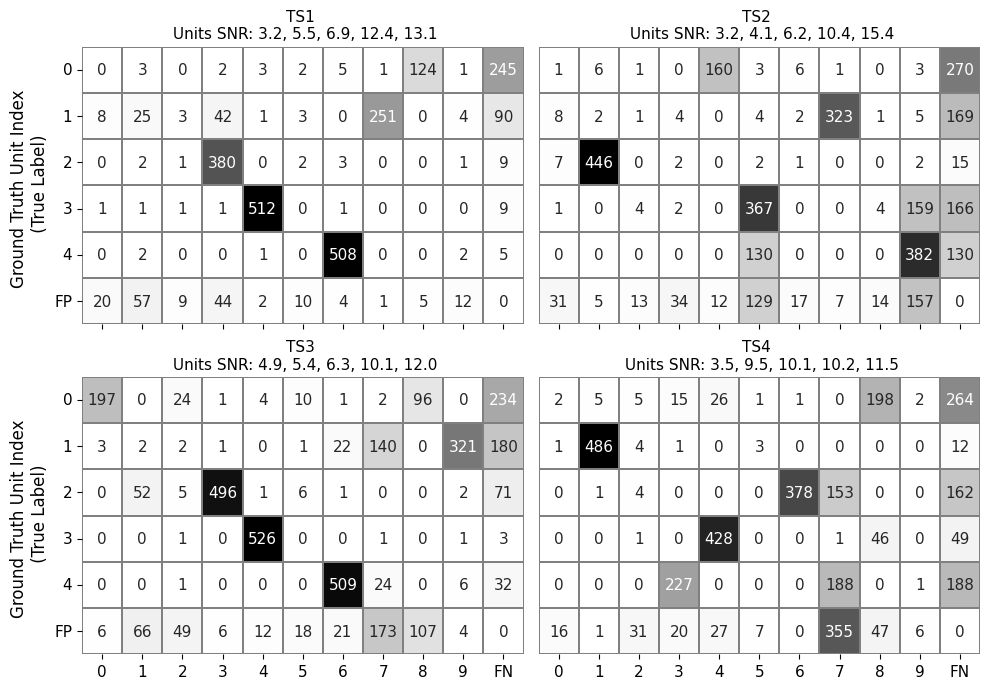

In [15]:
# plot confusion matrix
# load conf_matrices
with open("nss_confusion_matrices.pkl", "rb") as f:
    conf_matrices = pickle.load(f)

fig, axs = plt.subplots(2, 2, figsize=(10, 7), dpi=100, tight_layout=True, sharex=True)
axs = axs.flatten()
for ax, ds in zip(axs, conf_matrices.keys()):
    sns.heatmap(
        conf_matrices[ds]["conf_mat"].astype(int),
        annot=True,
        fmt="d",
        cmap="Greys",
        cbar=False,
        linewidths=0.05,
        linecolor="grey",
        annot_kws={"size": 11},
        ax=ax,
    )
    if ds == "TS1" or ds == "TS3":
        ax.set_ylabel("Ground Truth Unit Index \n (True Label)", fontsize=12)
    elif ds == "TS2" or ds == "TS4":
        ax.set_yticks([])
    ax.set_title(
        f"{ds} \n Units SNR: {conf_matrices[ds]['snr'][0]:.1f}, {conf_matrices[ds]['snr'][1]:.1f}, {conf_matrices[ds]['snr'][2]:.1f}, {conf_matrices[ds]['snr'][3]:.1f}, {conf_matrices[ds]['snr'][4]:.1f}",
        fontsize=11,
    )
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
plt.savefig(f"nss_confusion_matrix.svg", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
print(
    f"{ds} \n SNR : #1 {conf_matrices[ds]['snr'][0]:.1f}, #2 {conf_matrices[ds]['snr'][1]:.1f}, #3 {conf_matrices[ds]['snr'][2]:.1f}, #4 {conf_matrices[ds]['snr'][3]:.1f}, #5 {conf_matrices[ds]['snr'][4]:.1f}"
)